# Question 1

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [204]:
meanNegativeDS1 = pd.read_csv("Datasets/DS1_m_0.txt", header=None).drop([20], axis=1).as_matrix().flatten()
meanPositiveDS1 = pd.read_csv("Datasets/DS1_m_1.txt", header=None).drop([20], axis=1).as_matrix().flatten()
covDS1 = pd.read_csv("Datasets/DS1_Cov.txt", header=None).drop([20], axis=1).as_matrix()

In [205]:
dataNeg = np.random.multivariate_normal(meanNegativeDS1, covDS1, 2000)
dataPos = np.random.multivariate_normal(meanPositiveDS1, covDS1, 2000)

In [206]:
dataNegLabelled = np.append(dataNeg, np.zeros((2000, 1)), axis=1)
dataPosLabelled = np.append(dataPos, np.ones((2000, 1)), axis=1)

np.random.shuffle(dataNegLabelled)
np.random.shuffle(dataPosLabelled)

In [207]:
dataTrain = np.concatenate((dataNegLabelled[:1400], dataPosLabelled[:1400])) # 1400 = 70% of 2000
dataTest = np.concatenate((dataNegLabelled[1400:], dataPosLabelled[1400:]))

In [208]:
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)

In [209]:
# save dataset
dataTestTrain = np.concatenate((dataTrain, dataTest))
pd.DataFrame(data=dataTestTrain).to_csv("Datasets/DS1.csv")
pd.DataFrame(data=dataTest).to_csv("Datasets/DS1_test.csv")
pd.DataFrame(data=dataTrain).to_csv("Datasets/DS1_train.csv")

# Question 2

In [210]:
def splitNegPos(dataTrain):
    neg = []
    pos = []
    for row in dataTrain:
        if (row[20] == 0):
            neg.append(row)
        elif (row[20] == 1):
            pos.append(row)
        else:
            print "problem here"
    return np.asmatrix(neg), np.asmatrix(pos)

In [211]:
def calcMeanVectors(neg, pos):
    return np.mean(neg, axis=0).T, np.mean(pos, axis=0).T

In [212]:
def calcCovMatrix(neg, pos, negMean, posMean):
    negS = np.zeros((20,20))
    for row in neg:
        m = np.subtract(row, negMean.T)
        negS = negS + np.outer(m,m)
    
    posS = np.zeros((20,20))
    for row in pos:
        m = np.subtract(row, posMean.T)
        posS = posS + np.outer(m,m)
    
    return np.divide(np.add(negS, posS), (len(neg)+len(pos)))

In [213]:
# Compututation for training
neg, pos = splitNegPos(dataTrain)
negMean, posMean = calcMeanVectors(neg[:, :-1], pos[:, :-1])
print negMean
print posMean

[[1.31075372]
 [1.24121352]
 [1.27392147]
 [1.28518757]
 [1.29700413]
 [1.27735584]
 [1.32859703]
 [1.35771985]
 [1.30792921]
 [1.3310553 ]
 [1.28294456]
 [1.33119005]
 [1.32502052]
 [1.26371795]
 [1.32326695]
 [1.3953818 ]
 [1.26303064]
 [1.31569072]
 [1.28922682]
 [1.28404204]]
[[1.98969791]
 [1.95710686]
 [1.99483756]
 [2.06053192]
 [2.02865681]
 [1.95969669]
 [1.93895154]
 [1.9935373 ]
 [1.9723008 ]
 [2.01341369]
 [2.00306553]
 [1.99787338]
 [2.06843742]
 [2.05514725]
 [2.01465332]
 [1.96199881]
 [1.98194064]
 [2.02425157]
 [1.98310723]
 [2.10029022]]


In [214]:
cov = calcCovMatrix(neg[:, :-1], pos[:, :-1], negMean, posMean)
print cov

[[7.83301463 5.38626461 6.16466234 5.14069941 5.7958879  6.11576211
  4.54663589 5.44228543 4.9934017  5.2666217  3.90916169 5.228243
  7.09155688 5.96998888 6.01473396 5.93608321 5.86925324 5.68173222
  5.44327273 5.7743297 ]
 [5.38626461 6.77036209 5.28175983 4.27980464 5.44867927 5.46818824
  4.26784649 3.793345   4.13272396 5.00925202 3.37128608 4.5245329
  5.79920329 5.02462903 5.36683779 5.12756967 5.58119311 5.02463412
  5.19720064 5.22622053]
 [6.16466234 5.28175983 7.31114585 4.84787191 5.80110258 6.61326532
  4.55157697 4.83036194 4.92374543 5.1696072  3.30564726 4.63533652
  6.36247678 5.17992319 6.1032119  6.04685959 6.25177625 4.96550426
  4.61975331 5.02523216]
 [5.14069941 4.27980464 4.84787191 5.71664935 5.25695088 4.50404438
  3.63256713 4.39035041 3.38496325 4.26906731 2.78561296 4.12927115
  5.85567729 4.78554449 4.76208554 5.08158988 4.68474742 4.54272508
  3.85662925 5.66841514]
 [5.7958879  5.44867927 5.80110258 5.25695088 7.06184048 5.38635359
  4.97024292 4.3673

In [215]:
def trainLDA(negMean, posMean, cov, priorProb):
    w = np.dot(np.linalg.inv(cov), np.subtract(negMean, posMean))
    w0 = np.divide(np.dot(np.dot(negMean.T, np.linalg.inv(cov)), negMean), -2) + np.divide(np.dot(np.dot(posMean.T, np.linalg.inv(cov)), posMean), 2) + np.log(priorProb/(1-priorProb))
    return w, w0[0,0]

In [216]:
w, w0 = trainLDA(negMean, posMean, cov, 0.5) # Prior probability for negative class and positive class is 0.5
print w
print w0

[[ 13.90925363]
 [ -8.01235265]
 [ -5.52351363]
 [ -3.21283316]
 [ -9.24595305]
 [ -4.24420032]
 [ 16.370206  ]
 [-23.00400214]
 [-28.07743771]
 [  8.78945889]
 [-12.59414623]
 [-11.85377802]
 [ 15.05220526]
 [ 12.55298838]
 [ -5.47390201]
 [ 12.62387703]
 [ 28.35241496]
 [ -6.60694431]
 [ -0.86638513]
 [ -4.9059282 ]]
26.406942383894098


In [217]:
def sigmoid(a):
    return 1/(1+np.exp(-a))

In [218]:
def prediction(dataTest, w, w0):
    truePos, falsePos, falseNeg = 0, 0, 0
    for row in dataTest:
        label = row[-1]
        row = row[:-1]
        val = w0 + np.dot(w.T, row)
        if (sigmoid(val) < 0.5):
            if (label == 1):
                truePos += 1
            elif (label == 0):
                falsePos += 1
            else:
                print "problem here"
        else:
            if (label == 1):
                falseNeg += 1
                
    return truePos, falsePos, falseNeg

In [219]:
truePos, falsePos, falseNeg = prediction(dataTest, w, w0)

In [220]:
print truePos
print falsePos
print falseNeg
print (len(dataTest)-falsePos-falseNeg-truePos) # trueNeg

def evaluateConfusion(truePos, falsePos, falseNeg):
    accuracy = (float(len(dataTest)-falsePos-falseNeg))/len(dataTest)
    precision = float(truePos)/(truePos+falsePos)
    recall = float(truePos)/(truePos+falseNeg)
    fMeasure = 2*precision*recall/(precision+recall)
    return accuracy, precision, recall, fMeasure

accuracy, precision, recall, fMeasure = evaluateConfusion(truePos, falsePos, falseNeg)

print "Accuracy " + str(accuracy)
print "Precision " + str(precision)
print "Recall " + str(recall)
print "fMeasure " + str(fMeasure)

572
26
28
574
Accuracy 0.955
Precision 0.95652173913
Recall 0.953333333333
fMeasure 0.954924874791


# Question 3

In [221]:
def kNN(k, dataTrain, index, distances):
    indices = np.argpartition(distances[index], k)[:k]
    closestLabel = [dataTrain[i, -1] for i in indices]
    return np.argmax(np.bincount(closestLabel))

In [222]:
def getPredictions(k, dataTest, dataTrain, distances):
    return [kNN(k, dataTrain, i, distances) for i in range(len(dataTest))]

In [223]:
def getConfusion(predictedLabels, trueLabels):
    truePos, falsePos, falseNeg = 0, 0, 0
    for i in range(len(predictedLabels)):
        if predictedLabels[i] == 1:
            if (trueLabels[i] == 1):
                truePos += 1
            else:
                falsePos += 1
        else:
            if (trueLabels[i] == 1):
                falseNeg += 1
                
    return truePos, falsePos, falseNeg

In [224]:
def findBestK(dataTest, dataTrain, distances):
    f1 = []
    for k in range(1, 100):
        predictedLabels = getPredictions(k, dataTest, dataTrain, distances)
        tp, fp, fn = getConfusion(predictedLabels, dataTest[:, -1])
        a, p, r, f = evaluateConfusion(tp, fp, fn)
        f1.append(f)
    return np.argmax(f1)+1, f1

In [225]:
distances = [[np.linalg.norm(np.subtract(x, row)) for row in dataTrain[:, :-1]] for x in dataTest[:, :-1]]

In [226]:
bestK, fMeasures = findBestK(dataTest, dataTrain, distances)
print bestK

51


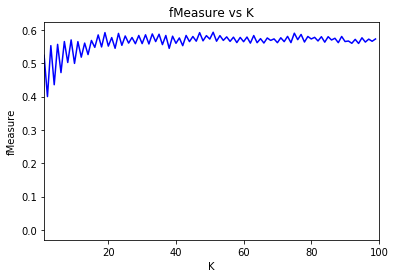

In [229]:
def plotFMeasureK(fMeasures):
    fixIndex = [0] + fMeasures
    plt.plot(fixIndex, c='b')
    plt.xlabel("K")
    plt.ylabel("fMeasure")
    plt.title("fMeasure vs K")
    plt.xlim(1, 100)
    
plotFMeasureK(fMeasures)

In [230]:
predictedLabels = getPredictions(bestK, dataTest, dataTrain, distances)
truePos, falsePos, falseNeg = getConfusion(predictedLabels, dataTest[:, -1])

print truePos
print falsePos
print falseNeg
print (len(dataTest)-falsePos-falseNeg-truePos) # trueNeg

accuracy, precision, recall, fMeasure = evaluateConfusion(truePos, falsePos, falseNeg)

print "Accuracy " + str(accuracy)
print "Precision " + str(precision)
print "Recall " + str(recall)
print "fMeasure " + str(fMeasure)

365
266
235
334
Accuracy 0.5825
Precision 0.578446909667
Recall 0.608333333333
fMeasure 0.593013809911


# Question 4

In [231]:
mean1PosDS2 = pd.read_csv('Datasets/DS2_c1_m1.txt', header = None).drop([20], axis=1).as_matrix().flatten()
mean2PosDS2 = pd.read_csv('Datasets/DS2_c1_m2.txt', header = None).drop([20], axis=1).as_matrix().flatten()
mean3PosDS2 = pd.read_csv('Datasets/DS2_c1_m3.txt', header = None).drop([20], axis=1).as_matrix().flatten()

mean1NegDS2 = pd.read_csv('Datasets/DS2_c2_m1.txt', header = None).drop([20], axis=1).as_matrix().flatten()
mean2NegDS2 = pd.read_csv('Datasets/DS2_c2_m2.txt', header = None).drop([20], axis=1).as_matrix().flatten()
mean3NegDS2 = pd.read_csv('Datasets/DS2_c2_m3.txt', header = None).drop([20], axis=1).as_matrix().flatten()

cov1 = pd.read_csv("Datasets/DS2_Cov1.txt", header=None).drop([20], axis=1).as_matrix()
cov2 = pd.read_csv("Datasets/DS2_Cov2.txt", header=None).drop([20], axis=1).as_matrix()
cov3 = pd.read_csv("Datasets/DS2_Cov3.txt", header=None).drop([20], axis=1).as_matrix()

In [232]:
dataNeg1 = pd.DataFrame(data = np.random.multivariate_normal(mean1NegDS2, cov1, 2000)).sample(frac=0.1)
dataNeg2 = pd.DataFrame(data = np.random.multivariate_normal(mean2NegDS2, cov2, 2000)).sample(frac=0.42)
dataNeg3 = pd.DataFrame(data = np.random.multivariate_normal(mean3NegDS2, cov3, 2000)).sample(frac=0.48)

dataNeg = np.concatenate((np.concatenate((np.array(dataNeg1), np.array(dataNeg2))), np.array(dataNeg3)))

dataPos1 = pd.DataFrame(data = np.random.multivariate_normal(mean1PosDS2, cov1, 2000)).sample(frac=0.1)
dataPos2 = pd.DataFrame(data = np.random.multivariate_normal(mean2PosDS2, cov2, 2000)).sample(frac=0.42)
dataPos3 = pd.DataFrame(data = np.random.multivariate_normal(mean3PosDS2, cov3, 2000)).sample(frac=0.48)

dataPos = np.concatenate((np.concatenate((np.array(dataPos1), np.array(dataPos2))), np.array(dataPos3)))

In [233]:
dataNeg = np.append(dataNeg,np.zeros((2000,1)), axis=1)
dataPos = np.append(dataPos,np.ones((2000,1)), axis=1)

np.random.shuffle(dataNeg)
np.random.shuffle(dataPos)

In [234]:
dataTrain = np.concatenate((dataNeg[:1400], dataPos[:1400])) # 1400 = 70% of 2000
dataTest = np.concatenate((dataNeg[1400:], dataPos[1400:]))

np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)

In [235]:
# save dataset
dataTestTrain = np.concatenate((dataTrain, dataTest))
pd.DataFrame(data=dataTestTrain).to_csv("Datasets/DS2.csv")
pd.DataFrame(data=dataTest).to_csv("Datasets/DS2_test.csv")
pd.DataFrame(data=dataTrain).to_csv("Datasets/DS2_train.csv")

# Question 5.1

In [236]:
# Compututation for training
neg, pos = splitNegPos(dataTrain)
negMean, posMean = calcMeanVectors(neg[:, :-1], pos[:, :-1])
print negMean
print posMean

[[1.28745075]
 [1.30680821]
 [1.22782105]
 [1.20889673]
 [1.26385601]
 [1.24842539]
 [1.21231605]
 [1.2733429 ]
 [1.21287657]
 [1.15305029]
 [1.22741302]
 [1.26697755]
 [1.22108494]
 [1.20308532]
 [1.30056108]
 [1.25425766]
 [1.23141902]
 [1.35449738]
 [1.15481195]
 [1.2492258 ]]
[[1.04672668]
 [1.05844091]
 [1.02170827]
 [1.07938353]
 [0.98293461]
 [1.09640948]
 [1.03432959]
 [1.02938333]
 [1.05707546]
 [1.05429878]
 [1.04345858]
 [1.03086226]
 [0.99881149]
 [1.0451089 ]
 [1.04919493]
 [1.04185004]
 [1.08182844]
 [1.07353928]
 [1.01112263]
 [1.08048638]]


In [237]:
cov = calcCovMatrix(neg[:, :-1], pos[:, :-1], negMean, posMean)

In [245]:
print cov

[[7.71059873 5.39812565 4.60525215 5.11732978 4.33574495 5.62332496
  5.97665273 5.76598763 4.69997554 5.4027417  5.5984332  4.98504982
  5.03694995 6.07576537 5.40557206 5.63984119 5.32134798 5.53244152
  5.5825669  5.77032284]
 [5.39812565 7.33669204 4.91021694 5.35394807 5.04292758 5.99303384
  6.607358   5.4900267  4.69345347 5.17381326 4.87690278 5.05140023
  4.97332759 6.06645919 5.68759841 6.02337174 5.22700426 5.19781308
  6.13736602 5.62138103]
 [4.60525215 4.91021694 6.63459066 5.18453758 4.75501391 4.76481989
  5.94385851 4.56099453 4.50536706 4.77547185 4.71866214 4.92089491
  5.09424527 5.94264625 5.30463269 4.88870804 5.28971612 4.40936346
  5.66367242 5.59993764]
 [5.11732978 5.35394807 5.18453758 6.77174033 4.26314381 5.58854425
  6.36121039 5.5130327  4.80040005 5.53359207 5.02916415 4.79334918
  5.05429447 5.5430401  5.39741852 5.41462654 5.18540063 5.24451705
  5.89034744 5.6866618 ]
 [4.33574495 5.04292758 4.75501391 4.26314381 5.64878776 4.65536568
  5.07042318 4.5

In [238]:
w, w0 = trainLDA(negMean, posMean, cov, 0.5) # Prior probability for negative class and positive class is 0.5
print w
print w0

[[ 0.01034595]
 [ 0.03382382]
 [ 0.02141851]
 [-0.04159208]
 [ 0.0554358 ]
 [ 0.00405057]
 [-0.00162285]
 [ 0.04429938]
 [-0.01298182]
 [-0.01177366]
 [ 0.00694139]
 [ 0.03549652]
 [ 0.06729035]
 [-0.02702815]
 [-0.02440235]
 [-0.03155231]
 [-0.02575758]
 [ 0.02308278]
 [-0.05627954]
 [-0.00845733]]
-0.07256552556910145


In [239]:
truePos, falsePos, falseNeg = prediction(dataTest, w, w0)

In [240]:
print truePos
print falsePos
print falseNeg
print (len(dataTest)-falsePos-falseNeg-truePos) # trueNeg

accuracy, precision, recall, fMeasure = evaluateConfusion(truePos, falsePos, falseNeg)

print "Accuracy " + str(accuracy)
print "Precision " + str(precision)
print "Recall " + str(recall)
print "fMeasure " + str(fMeasure)

322
307
278
293
Accuracy 0.5125
Precision 0.511923688394
Recall 0.536666666667
fMeasure 0.524003254679


# Question 5.2

In [241]:
distances = [[np.linalg.norm(np.subtract(x, row)) for row in dataTrain[:, :-1]] for x in dataTest[:, :-1]]

In [242]:
bestK, fMeasures = findBestK(dataTest, dataTrain, distances)
print bestK

23


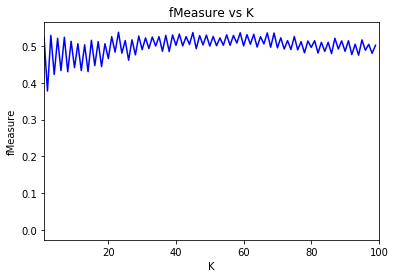

In [243]:
plotFMeasureK(fMeasures)

In [244]:
predictedLabels = getPredictions(bestK, dataTest, dataTrain, distances)
truePos, falsePos, falseNeg = getConfusion(predictedLabels, dataTest[:, -1])

print truePos
print falsePos
print falseNeg
print (len(dataTest)-falsePos-falseNeg-truePos) # trueNeg

accuracy, precision, recall, fMeasure = evaluateConfusion(truePos, falsePos, falseNeg)

print "Accuracy " + str(accuracy)
print "Precision " + str(precision)
print "Recall " + str(recall)
print "fMeasure " + str(fMeasure)

322
276
278
324
Accuracy 0.538333333333
Precision 0.538461538462
Recall 0.536666666667
fMeasure 0.537562604341
